### Лабораторная работа №5
#### Идентификация параметров линейного регрессионного объекта при α− загрязненных шумах

Пусть линейный регрессионный объект имеет вид:
$$ \large y(i)=с_{0}+с_{1}u_{1}(i)+...+с_{4}u_{4}(i)+\eta(i) , $$ 

где шум, действующий на объект, принадлежит классу приближенно нормальных распределений:
$ \large f(\eta) = (1-\alpha)f_N(\eta) + \alpha g(\eta) $ <br>
$ \large f_N(\eta) = \frac{1}{\sqrt{2 \pi} \sigma_\eta} exp(- \frac{\eta^2}{2 \sigma^2_\eta}) $ - нормальное распределение $ \large N(0, \sigma_\eta)$, <br>
$\large \alpha$ - вероятность появление выброса с рапределением $\large g(\eta)$ <br>
$\large g(\eta)$ - вообще говоря какое-то распределение, но в данной лабораторной работе будет нормальным $ \large N(0, \sigma_\eta (outlier))$, но его параметры отличны от $\large f_N(\eta)$

In [1]:
# параметры объекта 
c0=1.5
c1=2.5
c2=-3.5
c3=4.5
c4=5

In [2]:
# количество измерений
N=50

#### Сгенерируем шум, принадлежащий классу приближенно нормальных распределений

In [3]:
import numpy as np
from scipy.stats import rv_continuous

In [4]:
# класс для "загрязненного" распределения
class gaussian_gen(rv_continuous):
    
    def _pdf(self, x, alpha, sigma_1, sigma_2):
        "Gaussian distribution"
        def gaussian(self, x, sigma):
            return np.exp(-x**2 / 2. / sigma**2) / (np.sqrt(2.0 * np.pi)*sigma)
        
        return (1-alpha)*gaussian(self, x, sigma_1)+alpha*gaussian(self, x, sigma_2)

gaussian = gaussian_gen(name='dirty_distrib')

Зададим следующие параметры нашего загрязненного распределения для шума:

In [5]:
alpha = 0.3
ksi=0.9
sigma_1 = 0.5
sigma_2 = 100
Noise = gaussian.rvs(alpha, sigma_1, sigma_2, size=N)

#### Посмотрим на сгенерированный шум и увидим "выбросы" из другого распределения

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

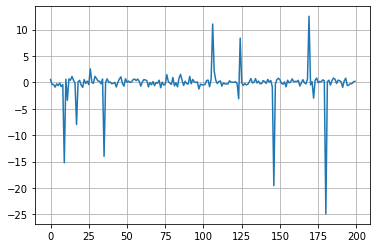

In [7]:
plt.plot(Noise)
plt.grid()

#### Зададим параметры входов объекта и смоделируем выход объекта

In [8]:
#Ваш код здесь
Avg_U1=0
Var_U1=10
Avg_U2=1
Var_U2=50
Avg_U3=0
Var_U3=1
Avg_U4=5
Var_U4=50

In [9]:
#Ваш код здесь
U1=np.random.normal(Avg_U1, Var_U1, N)
U2=np.random.normal(Avg_U2, Var_U2, N)
U3=np.random.normal(Avg_U3, Var_U3, N)
U4=np.random.normal(Avg_U4, Var_U4, N)

In [10]:
# моделирование выхода объекта
y=c0+c1*U1+c2*U2+c3*U3+c4*U4+Noise

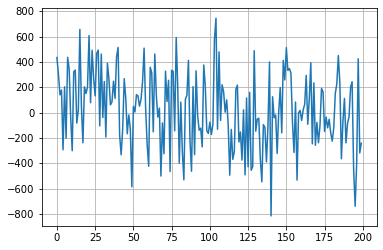

In [11]:
plt.plot(y)
plt.grid()

### Эффективность алгоритма Хубера vs Рекуррентным МНК при различных статистических характеристиках распределений

In [12]:
import math
from scipy.integrate import quad


def calc_fN(eta):
    return math.exp(-eta * eta / 2 / sigma_1 / sigma_1) / pow(2 * math.pi, 0.5) / sigma_1

class Huber:
    def __init__(self, lamb, ksi):
        self.lamb = lamb
        self.ksi = ksi
        
        # Fisher
        self.delta = self.ksi * sigma_1
        def integr(eta):
            return eta * eta * math.exp(-eta * eta / 2 / sigma_1 / sigma_1)
        
        If = (
            2 * (1 - alpha) * self.delta / sigma_1 / sigma_1 * calc_fN(self.ksi)
            + (1 - alpha) / pow(2 * math.pi, 0.5) / pow(sigma_1, 5) * quad(integr, -self.delta, self.delta)[0]
        )
        
        self.If = If
        
        self.c_estim_huber = []
    
    def fit(self, X, y, c0):
        # c0 = np.matrix([1.2, 2.7, -3.3, 4.2, 5.2]).T
        C = c0
        self.c_estim_huber.append(c0)
        G = self.lamb * np.eye(5)
        for i in range(1, N+1):
            eps = y[i-1] - C[0, 0] - C[1, 0] * X[0][i-1] - C[2, 0] * X[1][i-1] - C[3, 0] * X[2][i-1] - C[4, 0] * X[3][i-1]
            if eps <= -self.delta:
                d_eps = -self.delta
            elif eps >= self.delta:
                d_eps = self.delta
            else:
                d_eps = eps
            z = np.matrix([1, X[0][i-1], X[1][i-1], X[2][i-1], X[3][i-1]]).T    
            G = G - G * z * z.T * G / (pow(self.If, -1) + z.T * G * z)
            C = C + G * d_eps * z
            self.c_estim_huber.append(C)
    
    def get_coefs(self):
        return self.c_estim_huber
    
    
class RecurrentMLS:
    def __init__(self, lamb):
        self.lamb = lamb     
        self.c_estim_recMLS = []
    
    def fit(self, X, y, c0):
        # c0 = np.matrix([1.2, 2.7, -3.3, 4.2, 5.2]).T
        C = c0
        self.c_estim_recMLS.append(c0)
        G = self.lamb * np.eye(5)
        for i in range(1, N+1):
            eps = y[i-1] - C[0, 0] - C[1, 0] * X[0][i-1] - C[2, 0] * X[1][i-1] - C[3, 0] * X[2][i-1] - C[4, 0] * X[3][i-1]
            z = np.matrix([1, X[0][i-1], X[1][i-1], X[2][i-1], X[3][i-1]]).T    
            G = G - G * z * z.T * G / (1 + z.T * G *z)
            C = C + G * eps * z
            self.c_estim_recMLS.append(C)
    
    def get_coefs(self):
        return self.c_estim_recMLS

In [17]:
np.seterr('raise')
a = Huber(0.1, ksi)
a.fit([U1, U2, U3, U4], y, np.matrix([1.2, 2.7, -3.3, 4.2, 5.2]).T)
coefs_1 = a.get_coefs()
print(coefs_1[-1])

b = RecurrentMLS(0.1)
b.fit([U1, U2, U3, U4], y, np.matrix([1.2, 2.7, -3.3, 4.2, 5.2]).T)
coefs_2 = b.get_coefs()
print(coefs_2[-1])

[[ 1.21899138]
 [ 2.67514509]
 [-3.33482822]
 [ 4.42067997]
 [ 5.17848555]]
[[ 1.28494815]
 [ 2.54351943]
 [-3.50486924]
 [ 4.56672877]
 [ 5.00043296]]


In [14]:
def smooth_errors(c_estim, c_true):
    ERR = []
    for i in range(10, N):
        err = 0
        for j in range(1, 11):
            for k in range(5):
                err += (c_estim[i - j][k, 0] - c_true[k]) ** 2
        err /= 10
        err = err ** 0.5
        ERR.append(err)
    return(ERR)

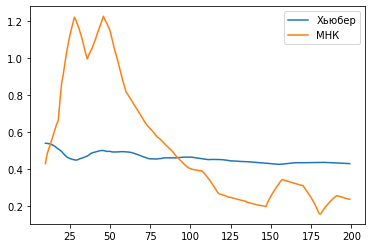

In [15]:
err1 = smooth_errors(coefs_1, [c0, c1, c2, c3, c4])
err2 = smooth_errors(coefs_2, [c0, c1, c2, c3, c4])
x = [x for x in range(10, N)]
plt.plot(x, err1, label='Хьюбер')
plt.plot(x, err2, label='МНК')
plt.legend()

В лабораторной работе требуется:

1. Реализовать __class Huber__ c методами: <br>
   * в конструкторе класса небходимо задать:<br>
     1) λ в формуле задания начального приближения матрицы Г(0) = λ*I <br>
    2) параметр $ \xi $, участвующий в функции потерь Хьюбера, в зависимости от вероятности появления выброса $ \alpha $ (значения которого приведены в описании ЛР) <br><br>
   *   __def fit(X, y, c0)__ - метод реализует алгоритм итерационного оценивания параметов объекта с использованием функции потерь Хьюбера:<br>
        <br>
        Input:<br>
            X - матрица входов объекта, [X] = m x N <br>
            y - вектор выходов объекта, [y] = N <br>
            с0 - вектор начального приближения, [c0] = m <br>
        <br>       
   * __def get_coefs()__ - метод возвращает массив коэффициентов оценок вектора параметров объекта, получаемого на каждом новом шаге измерений<br>
        <br>
        Output:<br>
            c_estim_huber - массив оценок параметров объекта, полученный в результате работы метода fit<br><br>
2. Реализовать __class RecurrentMLS__ с методами: <br>

    * в конструкторе класса небходимо задать:<br>
     1) λ в формуле задания начального приближения матрицы Г(0) = λ*I <br><br>

    * __def fit(X, y, c0)__ - метод реализует алгоритм итерационного оценивания параметов объекта с использованием квадратичной функции потерь (см. 2 лабораторную работу):<br>
         <br>
     Input:<br>
             X - матрица входов объекта, [X] = m x N<br>
             y - вектор выходов объекта, [y] = N<br>
             с0 - вектор начального приближения, [c0] = m+1<br><br>
        
    * __def get_coefs()__ - метод возвращает массив коэффициентов оценок вектора параметров объекта, получаемого на каждом новом шаге измерений<br>
        <br>
        Output:<br>
            c_estim_recMLS - массив оценок параметров объекта, полученный в результате работы метода fit<br><br>        
3. Реализовать функцию __smooth_errors(c_estim, c_true)__  - вычисляет сглаженную ошибку оценки по 10 измерениям. <br>
         Input: 
             c_estim - массив оценок параметров объекта, [c_estim] = m+1 x N
             c_true - вектор истинных параметров объекта, [c_true] = m+1 
         Output:
             err - массив сглаженных ошибок оценки
              
4. Провести исследование эффективности алгоритма Хубера по сравнению с рекуррентным МНК алгоритмом при следующих статистических характеристиках распределений:<br>
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.1    $\sigma_\eta (outlier)$ = 10;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.1    $\sigma_\eta (outlier)$ = 50;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.1    $\sigma_\eta (outlier)$ = 100;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.3    $\sigma_\eta (outlier)$ = 10;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.3    $\sigma_\eta (outlier)$ = 50;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.3    $\sigma_\eta (outlier)$ = 100. <br><br>
5. Построить графики сходимости сглаженной ошибки оценки по двум алгоритмам: алгоритм с использованием теоремы Хубера и рекуррентный алгоритм, соответствующий методу наименьших квадратов. Сдалать выводы.

### Hints

1. Рекуррентный алгоритм при функции потерь Хьюбера имеет вид:
\begin{equation} \large \hat{\vec{c}}(i)=\hat{\vec{c}}(i-1)+Г(i)d(\varepsilon(i, \hat{\vec{c}}(i-1)))\vec{z}(i) \\
\large Г(i)=Г(i-1)-\frac{Г(i-1)\vec{z}(i)\vec{z}(i)^TГ(i-1)}{I^{-1}_F+\vec{z}^T(i)Г(i-1)\vec{z}(i)} \\
\large Г(0)=\lambda I, \lambda >> 1,  \hat{\vec{c}}(0)=\vec{c}_{0}\end{equation}

где $ \large  \Delta = \xi\sigma_\eta$
\begin{equation} \large d(\varepsilon(i, \hat{\vec{c}}(i-1)))=\frac{dF(\varepsilon(i, \hat{\vec{c}}(i-1)))}{d\varepsilon}|_{\varepsilon = \varepsilon(i, \hat{\vec{c}}(i-1)))}= \left\{
    \begin{array}\\
        -\Delta, & \varepsilon(i) \leq -\Delta \\
        \varepsilon(i, \hat{\vec{c}}(i-1))), & -\Delta \leq |\varepsilon(i)| \leq \Delta\\
        \Delta, &  \varepsilon(i) \geq \Delta
    \end{array}  
\right.\end{equation}

\begin{equation} \large  I_F=2(1-\alpha)\frac{\Delta}{\sigma^2_\eta}f_N(\frac{\Delta}{\sigma_\eta})+(1-\alpha)\frac{1}{\sqrt{2\pi}\sigma_\eta}\frac{1}{\sigma^4_\eta}\int_{-\Delta}^\Delta \eta^2exp(\frac{-\eta^2}{2\sigma^2_\eta})d\eta\end{equation}

2. Для вычислении информации Фишера можно использовать модуль __sympy__ (https://docs.sympy.org/latest/modules/integrals/integrals.html)